# Previsão do tempo da cidade de São João del-Rei utilizando modelos de Machine Learning

## Metodologia
### Dados
Os dados utilizados no projeto são dados climáticos que foram obtidos através do site do INMET (Instituto Nacional de Meteorologia, https://portal.inmet.gov.br/).
As medições são realizadas por uma estação automática que fica localizada no Campos Tancredo Neves (CTAN), a uma altitude de 929.88 metros, e atualiza os dados horariamente.
Dentre os dados climáticos gerados pela estação, é possível observar informações como: data e hora da medição, precipitação total (chuva), pressão atmosférica, radiação global, temperatura do ar, temperatura do ponto de orvalho, umidade relativa do ar e direcao e velocidade do vento.
O intervalo de tempo dos dados utilizados nesse projeto tem início em 08 de junho de 2006, quando a estação é instalada, e ainda não possui uma data final definida, pelo fato de que os dados estão sendo produzidos diariamente, porém os dados aqui apresentados vão até o dia 06 de maio de 2023.

In [21]:
# imports and settings
import datetime
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [36]:
# carrega os dados
df = pd.read_csv('https://raw.githubusercontent.com/srlucasromulo/PPGCC-DS-DeepLearning/main/data/sjdr.csv', low_memory=False, sep=',')
df.data_hora = df.data_hora.astype('datetime64')
df.data = df.data.apply(lambda x: datetime.date.fromisoformat(x))
df.hora = df.hora.apply(lambda x: datetime.time.fromisoformat(x))

In [ ]:
# define vetor de xticks and xlabels utilizados nas imagens
x_ticks = []
x_labels = []
for i in range(len(df)):
	data_hora = df.loc[i]['data_hora']
	if data_hora.day == 1 and data_hora.month == 1 and data_hora.hour == 0:
		x_ticks.append(i)
		x_labels.append(data_hora.year)

In [ ]:
# sample
df.sample(10)

#### Temperatura do ar (°C)
A temperatura do ar, medida em graus Celsius, é a variável target do trabalho, e representa a temperatura aferia por um termômetro de bulbo seco no início de cada hora.
Características:


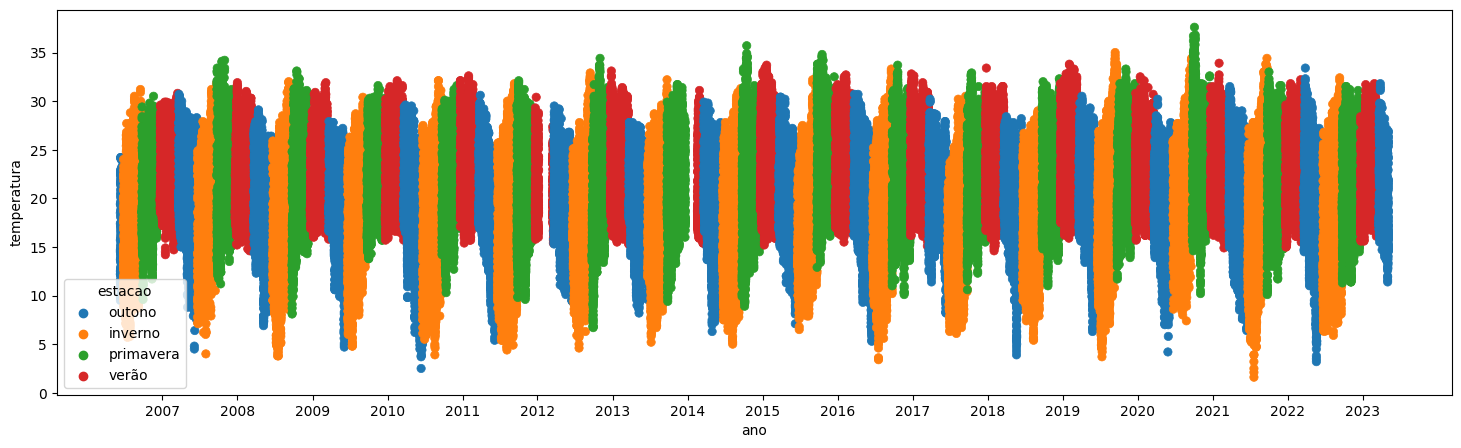

In [40]:
plt.figure(figsize=(18,5))
sns.scatterplot(df, x='time', y='temperatura', hue='estacao', edgecolor=None, markers='.')
plt.xlabel('ano')
plt.xticks(ticks=x_ticks, labels=x_labels)